# Data Sciencie Challengue

- ¿Qué problema se quiso resolver con el desarrollo de la solución?

Segmentación Seller
- ¿Qué información buscaste y utilizaste para el desarrollo de la solución? 

información de ítem detalle e ítem sellers
- Muestra los insights más relevantes que hayas obtenido de tu análisis exploratorio.

Las categorías con mayores ventas en monto son de vestuario y calzado, computación y electrodomésticos. en general se puede observar que la primera categoría genera gran cantidad de ítems vendidos, pero con una venta promedio de venta más baja, a su vez computación tiene menos ventas, pero su venta promedio es más alta. Lo que nos dice claramente es que hay diferencias entre los ítems en precio por categoría.

La antigüedad de los seller influye en su venta donde se observa que para seller más antiguos (mayor a 5 años) su venta comienza a disminuir

- Danos un contexto de la solución que escogiste, y cómo la abordaste. ¿Qué
metodologías aplicaste? ¿Qué métricas de evaluación utilizaste?

Dada la información disponible de los seller se propuso perfilar a los sellers en base a modelos no supervisados como K-medias,
sin embargo dada la poca variabilidad en la información no hubieron resultados esperados, los segmentos por k-medias no separaron la población de una manera natural es por ello que se perfiló en base a quintiles puntuando de mejor manera a aquellos que tienen mejores medidas en variables claves como monto total vendido, cantidad de ítems disponibles, para ver el buen de desempeño de un seller. 
Las ventajas de utilizar quintiles o cualquier medida de percentil, es que al analizarlo garantiza una observación directa sobre si una variable para un sellers es bajo, medio y alto, por lo cual se puede hacer una gestión en base ese estado, y potenciarlo sobre ese atributo en especial.

- ¿Cuál es tu solución final? ¿Cómo se comporta? ¿Cómo soluciona o ayuda a
solucionar el problema de negocio?

La solución final consiste en segmentar a los sellers en base a quintiles de variables claves y luego ponderar dando mayor puntuación a los que están en los quintiles más altos y menor a los más bajo, de esta forma uno puede tomar distintas estrategias según el quintil al que este observando, por ejemplo para los quintiles más bajos es probable que tengan menos ventas o menos cantidad de ítem podría existir una campaña para fomentar que venda más productos, a su vez los quintiles más altos daría incentivos para mantener su potencial. Es importante analizar las campañas/estrategias que tienen para Sellers y empezar a relacionarlas a los distintos tramos propuestos.

- Concluye y plantea próximos pasos que harías después de entregar esta solución.

Tratamiento de blancos y nulos

Probar quintiles por segmentos de categoría, antigüedad y localización.

Optimizar Código para ejecución automática y para reentreno de rangos de percentiles

Monitoreo de estrategias y campañas


## Importe librerias

In [278]:
import requests
import pandas as pd
import numpy as np
import json
import time
import csv
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())
import datetime
import os
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

## Funciones

In [2]:

def get_all_category(pais):
    cats = requests.get('https://api.mercadolibre.com/sites/'+pais+'/categories')
    json_data = cats.json()
    df_cats = pd.json_normalize(json_data)
    return df_cats


def get_products_by_category(pais,category, n_fetch=1000):
    base_url = 'https://api.mercadolibre.com/sites/'+pais+'/search'
#    offset = 0
    products = []
    for offset in pam_offset:
        print(offset)
        response = requests.get(base_url, params={'category': category, 'offset': offset})
        data = response.json()
        if not data['results']:
            break
        products.extend(data['results'])

    
    return products


def get_products_detail(product_ids):
    sep = ','
    product_ids = sep.join(product_ids)
    base_url = f'https://api.mercadolibre.com/items?ids={product_ids}'
    response = requests.get(base_url).json()
    item_list = []
    for item in response:
        try:
            item_list.append(item['body'])
        except:
            continue
    return item_list




## Parametros

In [143]:
os.chdir("C:/Users/svescovij/MELI_Challenge/Data")
## Pais para analizar items 
pais = 'MLC'        
offset_ = 1000      
batch_size = 20 ##maximo de busqueda de item
# Atributos rama Json results
pam_variable = ["seller"] 


## Carga de categorias

In [34]:
cats = requests.get('https://api.mercadolibre.com/sites/'+pais+'/categories')
json_data = cats.json()
df_cats = pd.json_normalize(json_data)
pam_categoria = df_cats['id']

## Construccion de tablon Item-seller

In [144]:
# Declaro Dataframe para cosntruir Tablon
df_item = pd.DataFrame()
df_parametro = pd.DataFrame()

pam_offset = []
##

for i in range(0, offset_, 50):
    pam_offset.append(i)
pam_offset.append(offset_)
##

df_item=[]
for cat_id in pam_categoria:
    print(cat_id)
    for offset in pam_offset:
            # Busca en la api por offset y categoria
            url = f'https://api.mercadolibre.com/sites/MLC/search?category={cat_id}&offset={offset}'    
            request = requests.get(url)
            items = request.json()
            # Convierte json en Dataframe
            if not items["results"]:
                break

            df = pd.DataFrame(items["results"])
            df['cat_id']=cat_id

           
            for parametro in pam_variable:
                try:
                    # Crea un nuevo DataFrame con los datos correspondientes al parametro  
                    df_variable = pd.json_normalize(df[parametro])
                    df_variable = df_variable.add_prefix(parametro+'_')
                
                    # Concatena el nuevo DataFrame al DataFrame existente
                    df = pd.concat([df, df_variable], axis=1)
                except :
                    continue
                

            # Uno base con todos los atributos
            if len(df_item) > 0 :
                df_item= pd.concat([df_item, df], ignore_index = True)
            else:
                df_item = df



MLC1747
MLC1512
MLC1403
MLC1071
MLC1367
MLC1368
MLC1743
MLC1384
MLC1246
MLC1039
MLC1051
MLC1648
MLC1144
MLC1500
MLC1276
MLC5726
MLC1000
MLC110931
MLC178483
MLC1574
MLC1499
MLC1459
MLC1182
MLC1132
MLC3025
MLC1168
MLC3937
MLC409431
MLC1540
MLC435280
MLC1430
MLC1953


## Construccion de tablon Item-Detalle

In [147]:
product_details = []
ids_list = []
## Obtengo categorias del pais seleccionado
categories=get_all_category(pais)


## Listas de todos los productos por categoria segun parametro de offset y pais
for cat_id in categories['id']:
    print(cat_id)
    products_list = get_products_by_category(pais,cat_id, offset)
    ids_list.extend([product['id'] for product in products_list])

## obtengo detalle de todos los producto de la lista anterior
for step, _ in enumerate(range(0, len(ids_list), batch_size)):
    print(step)
    ids_to_query = ids_list[step*batch_size:batch_size*(step+1)]
    product_details.extend(get_products_detail(ids_to_query))

## Convierto en dataframe lista anterior
data = pd.DataFrame(product_details)



MLC1747
0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
MLC1512
0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
MLC1403
0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
MLC1071
0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
MLC1367
0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
MLC1368
0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
MLC1743
0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
MLC1384
0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
MLC1246
0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
MLC1039
0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
MLC1051
0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
MLC1648
0


## Descriptivo

In [188]:
# Descriptivo Item detalle
#data.columns
data.describe()

,seller_id,official_store_id,price,base_price,original_price,initial_quantity,available_quantity,sold_quantity,health
count,3.256200e+04,4994.000000,3.189700e+04,3.189700e+04,9.824000e+03,32562.000000,32562.000000,32562.000000,19315.000000
mean,4.933745e+08,3029.877253,5.589651e+05,5.589651e+05,7.632895e+04,737.734752,85.876113,264.232940,0.820361
std,3.611625e+08,9960.108611,3.853409e+06,3.853409e+06,2.160636e+05,3381.584851,698.164529,1202.311066,0.137410
min,9.287100e+04,22.000000,1.000000e+00,1.000000e+00,7.500000e+02,0.000000,0.000000,0.000000,0.250000
25%,2.058952e+08,663.000000,7.990000e+03,7.990000e+03,8.990000e+03,19.000000,1.000000,5.000000,0.750000
50%,3.996135e+08,1168.000000,1.798000e+04,1.798000e+04,1.899400e+04,115.000000,1.000000,50.000000,0.850000
75%,6.862164e+08,1526.000000,4.274000e+04,4.274000e+04,4.826325e+04,501.000000,12.000000,250.000000,0.900000
max,1.424950e+09,54542.000000,2.089900e+08,2.089900e+08,5.999990e+06,243775.000000,50000.000000,109825.000000,1.000000


In [189]:
# Descriptivo Item seller
#df_item.columns
df_item.describe()

,order_backend,price,original_price,sold_quantity,available_quantity,official_store_id,seller_id,seller_seller_reputation.transactions.canceled,seller_seller_reputation.transactions.completed,seller_seller_reputation.transactions.ratings.negative,...,seller_eshop.eshop_status_id,seller_eshop.eshop_experience,seller_eshop.eshop_rubro,seller_seller_reputation.metrics.claims.excluded.real_value,seller_seller_reputation.metrics.claims.excluded.real_rate,seller_seller_reputation.metrics.delayed_handling_time.excluded.real_value,seller_seller_reputation.metrics.delayed_handling_time.excluded.real_rate,seller_seller_reputation.metrics.cancellations.excluded.real_value,seller_seller_reputation.metrics.cancellations.excluded.real_rate,reservation_price
count,32607.000000,3.194200e+04,9.804000e+03,32607.000000,32607.000000,5010.000000,3.260700e+04,32607.000000,32607.000000,32607.000000,...,9377.000000,9377.000000,0.0,687.000000,687.000000,688.000000,688.000000,687.000000,687.000000,1050.0
mean,25.494035,5.597735e+05,7.649032e+04,261.361057,83.880424,3022.970259,4.933177e+08,1106.570798,27600.980556,0.098636,...,1.222672,110.553162,NaN,52.328967,0.020314,224.680233,0.082650,10.579330,0.009856,50000.0
std,14.428471,3.854147e+06,2.163745e+05,1291.508786,624.540089,9948.147751,3.612684e+08,2220.479582,54753.484968,0.118497,...,0.425191,458.628455,NaN,108.044962,0.028570,492.355237,0.109576,24.738145,0.032847,0.0
min,1.000000,1.000000e+00,7.500000e+02,0.000000,1.000000,22.000000,9.287100e+04,0.000000,0.000000,0.000000,...,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50000.0
25%,13.000000,7.990000e+03,8.990000e+03,5.000000,1.000000,663.000000,2.061858e+08,89.000000,2046.000000,0.020000,...,1.000000,0.000000,NaN,1.000000,0.005500,2.000000,0.012375,0.000000,0.000000,50000.0
50%,25.000000,1.798000e+04,1.899000e+04,50.000000,1.000000,1168.000000,3.996135e+08,368.000000,9293.000000,0.070000,...,1.000000,0.000000,NaN,6.000000,0.016800,16.000000,0.054400,2.000000,0.001500,50000.0
75%,38.000000,4.290000e+04,4.799000e+04,250.000000,50.000000,1526.000000,6.858402e+08,942.000000,24298.500000,0.130000,...,1.000000,0.000000,NaN,18.500000,0.026300,48.000000,0.108200,6.500000,0.009800,50000.0
max,50.000000,2.089900e+08,5.999990e+06,50000.000000,50000.000000,54542.000000,1.424950e+09,22413.000000,352312.000000,1.000000,...,2.000000,2019.000000,NaN,336.000000,0.333300,1517.000000,1.000000,169.000000,0.333300,50000.0


## Seleccion de variables y construccion de antiguedad

In [195]:
# Me quedo con solo la informacion de los seller
cols = [col for col in df_item.columns if col.startswith('seller_') or col == 'id' or col == 'category_id' or col == 'cat_id']
df = df_item[cols]
df_seller = df.drop_duplicates(subset=('id','category_id','cat_id','seller_id'))
cols_seller = ['id','category_id','cat_id','seller_id','seller_nickname','seller_car_dealer'
                       ,'seller_registration_date','seller_seller_reputation.level_id'
                       ,'seller_seller_reputation.power_seller_status','seller_seller_reputation.transactions.canceled'
                       ,'seller_seller_reputation.transactions.completed','seller_seller_reputation.transactions.ratings.positive'
                       ,'seller_seller_reputation.transactions.total']
df_seller2 = df_seller[cols_seller]

# selecciono columnas y quito duplicados
cols = ['id','title','seller_id','category_id','price','initial_quantity','available_quantity','sold_quantity','start_time','health']
data2 = data[cols]
data2 = data2.drop_duplicates(subset=('id','category_id','seller_id'))

## Join entre info items e info sellers
df_final = data2.merge(df_seller2, how='left', on=['id','category_id','seller_id'])

# Calculo de antiguedad item y seller
today = datetime.date.today()
df_final['start_time'] = pd.to_datetime(df_final['start_time']).dt.date
df_final['seller_registration_date'] = pd.to_datetime(df_final['seller_registration_date']).dt.date

df_final['antiguedad_item']=(today - df_final['start_time']).dt.days
df_final['antiguedad_seller']=(today - df_final['seller_registration_date']).dt.days



In [196]:
df_final.describe()

,seller_id,price,initial_quantity,available_quantity,sold_quantity,health,seller_seller_reputation.transactions.canceled,seller_seller_reputation.transactions.completed,seller_seller_reputation.transactions.ratings.positive,seller_seller_reputation.transactions.total,antiguedad_item,antiguedad_seller
count,3.245400e+04,3.178900e+04,32454.000000,32454.000000,32454.000000,19285.000000,31999.000000,31999.000000,31999.000000,31999.000000,32454.000000,31999.000000
mean,4.931704e+08,5.607968e+05,737.948204,85.804123,264.580791,0.820303,1105.345073,27602.365574,0.783364,28707.710647,385.689561,2033.340729
std,3.612755e+08,3.859821e+06,3386.527985,698.638381,1204.290721,0.137466,2220.601830,54869.021033,0.276888,56946.269749,432.325976,1577.539828
min,9.287100e+04,1.000000e+00,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,2.000000,11.000000
25%,2.058952e+08,7.990000e+03,19.000000,1.000000,5.000000,0.750000,89.000000,2022.000000,0.780000,2142.000000,89.000000,950.000000
50%,3.996135e+08,1.798200e+04,115.000000,1.000000,50.000000,0.850000,366.000000,9277.000000,0.880000,9716.000000,226.000000,1623.000000
75%,6.862164e+08,4.290000e+04,501.000000,12.000000,250.000000,0.900000,942.000000,24291.000000,0.940000,25191.000000,529.750000,2724.000000
max,1.424950e+09,2.089900e+08,243775.000000,50000.000000,109825.000000,1.000000,22413.000000,352312.000000,1.000000,365035.000000,2764.000000,8553.000000


In [687]:
df_final.corr()

C:\Users\svescovij\AppData\Local\Temp\ipykernel_47000\2875322423.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_final.corr()


,seller_id,price,initial_quantity,available_quantity,sold_quantity,health,seller_seller_reputation.transactions.canceled,seller_seller_reputation.transactions.completed,seller_seller_reputation.transactions.ratings.positive,seller_seller_reputation.transactions.total,antiguedad_item,antiguedad_seller
seller_id,1.000000,0.044132,-0.020320,0.009702,-0.024114,0.021053,-0.079323,-0.081899,-0.160943,-0.082005,-0.254543,-0.808630
price,0.044132,1.000000,-0.030938,-0.016923,-0.031292,-0.296123,-0.067662,-0.069784,-0.321513,-0.069878,-0.111223,0.002660
initial_quantity,-0.020320,-0.030938,1.000000,0.407980,0.819317,0.027542,0.163337,0.160270,0.056057,0.160793,0.217228,-0.004823
available_quantity,0.009702,-0.016923,0.407980,1.000000,0.096083,0.021485,0.041439,0.033864,0.013103,0.034245,0.070347,-0.018816
sold_quantity,-0.024114,-0.031292,0.819317,0.096083,1.000000,0.016836,0.171653,0.171273,0.063465,0.171719,0.214108,0.000051
health,0.021053,-0.296123,0.027542,0.021485,0.016836,1.000000,-0.030042,-0.034649,0.037446,-0.034542,-0.018003,-0.067273
seller_seller_reputation.transactions.canceled,-0.079323,-0.067662,0.163337,0.041439,0.171653,-0.030042,1.000000,0.932916,0.093044,0.937880,0.127907,-0.025811
seller_seller_reputation.transactions.completed,-0.081899,-0.069784,0.160270,0.033864,0.171273,-0.034649,0.932916,1.000000,0.120119,0.999901,0.120965,-0.020396
seller_seller_reputation.transactions.ratings.positive,-0.160943,-0.321513,0.056057,0.013103,0.063465,0.037446,0.093044,0.120119,1.000000,0.119366,0.265594,0.133440
seller_seller_reputation.transactions.total,-0.082005,-0.069878,0.160793,0.034245,0.171719,-0.034542,0.937880,0.999901,0.119366,1.000000,0.121540,-0.020659


In [430]:
#Categorias más vendidas
category_ventas = pysqldf("SELECT a.cat_id,b.name,count(*) as cantidad_item,sum(sold_quantity) as unidades_vendidas,sum(sold_quantity*price) as total_generado,sum(sold_quantity*price)/sum(sold_quantity) as valor_promedio  FROM df_final a left join categories b on a.cat_id=b.id group by b.name ")


category_ventas = category_ventas.sort_values('total_generado', ascending=False)
category_ventas

,cat_id,name,cantidad_item,unidades_vendidas,total_generado,valor_promedio
32,MLC1430,Vestuario y Calzado,1041,798208,1.024300e+10,12832.490679
11,MLC1648,Computación,1020,337567,9.742670e+09,28861.441343
16,MLC5726,Electrodomésticos,1028,216614,9.664651e+09,44616.927405
21,MLC1499,Industrias y Oficinas,1023,940932,9.516257e+09,10113.649915
10,MLC1051,Celulares y Telefonía,1028,220716,9.166140e+09,41529.116412
20,MLC1574,Hogar y Muebles,999,483672,9.081101e+09,18775.328247
17,MLC1000,"Electrónica, Audio y Video",1023,330095,8.938375e+09,27078.189309
1,MLC1747,Accesorios para Vehículos,965,533187,8.439890e+09,15829.137622
19,MLC178483,Herramientas,1027,301864,7.417457e+09,24572.180426
15,MLC1276,Deportes y Fitness,1038,417700,7.136249e+09,17084.628295


In [673]:
# Seller
df_seller3=df_seller2.drop_duplicates(subset=('cat_id','seller_id'))
df_seller3['tasa_cancelados']=df_seller3['seller_seller_reputation.transactions.canceled']/df_seller3[ 'seller_seller_reputation.transactions.total']
df_seller3['tasa_realizados']=df_seller3['seller_seller_reputation.transactions.completed']/df_seller3[ 'seller_seller_reputation.transactions.total']

sellers_ventas = pysqldf("SELECT cat_id,seller_id,count(*) as cantidad_item,max(seg_antiguedad_seller) as seg_antiguedad_seller,max(antiguedad_seller) as antiguedad_seller,sum(sold_quantity) as unidades_vendidas,sum(sold_quantity*price) as total_generado , avg(health) as prom_health FROM df_final   group by cat_id,seller_id ")
sellers_ventas = sellers_ventas.merge(df_seller3, how='left', on=['cat_id','seller_id'])
sellers_ventas.describe()


C:\Users\svescovij\AppData\Local\Temp\ipykernel_47000\1135687448.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_seller3['tasa_cancelados']=df_seller3['seller_seller_reputation.transactions.canceled']/df_seller3[ 'seller_seller_reputation.transactions.total']
C:\Users\svescovij\AppData\Local\Temp\ipykernel_47000\1135687448.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_seller3['tasa_realizados']=df_seller3['seller_seller_reputation.transactions.completed']/df_seller3[ 'seller_seller_reputatio

,seller_id,cantidad_item,antiguedad_seller,unidades_vendidas,total_generado,prom_health,seller_seller_reputation.transactions.canceled,seller_seller_reputation.transactions.completed,seller_seller_reputation.transactions.ratings.positive,seller_seller_reputation.transactions.total,tasa_cancelados,tasa_realizados
count,1.089000e+04,10890.000000,10562.000000,10890.000000,1.036600e+04,7420.000000,10562.000000,10562.000000,10562.000000,10562.000000,9503.000000,9503.000000
mean,5.320291e+08,2.980165,2009.058796,788.494490,1.407305e+07,0.813735,661.065518,15053.040712,0.747829,15714.106230,0.056145,0.943855
std,3.918143e+08,10.877488,1705.485490,4242.836572,8.252666e+07,0.138617,1631.283899,36295.527153,0.314520,37840.539453,0.092346,0.092346
min,9.287100e+04,1.000000,11.000000,0.000000,0.000000e+00,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.020668e+08,1.000000,772.000000,5.000000,1.943675e+05,0.750000,28.000000,620.250000,0.730000,657.250000,0.031258,0.943149
50%,4.456490e+08,1.000000,1471.000000,100.000000,1.835000e+06,0.835000,177.000000,3944.000000,0.880000,4179.000000,0.042215,0.957785
75%,7.614110e+08,2.000000,2762.750000,500.000000,8.136144e+06,0.890000,562.000000,13139.000000,0.940000,13805.000000,0.056851,0.968742
max,1.424950e+09,858.000000,8553.000000,245925.000000,5.456565e+09,1.000000,22413.000000,352312.000000,1.000000,365035.000000,1.000000,1.000000


In [268]:
## Sellers con mas dinero vendido
sellers_ventas = sellers_ventas.sort_values('total_generado', ascending=False)
sellers_ventas[['seller_nickname','seller_id','cat_id']].head(10)

,seller_nickname,seller_id,cat_id
1245,MERCADOLIBRE ELECTRONICA_CL,550063615,MLC1051
10684,SACTI,325982945,MLC5726
4562,NESTLE E-COMMERCE,445649004,MLC1403
7827,MERCADOLIBRE ELECTRONICA_CL,550063615,MLC1648
552,CAIXUN,543504573,MLC1000
9075,SBD CHILE,494183906,MLC178483
7806,HP TIENDAOFICIAL,433323657,MLC1648
4724,INDUSBORD,173175749,MLC1430
554,MERCADOLIBRE ELECTRONICA_CL,550063615,MLC1000
10760,COMERCIALIZADORALOSROBLESLT,600275643,MLC5726


In [231]:
sellers_ventas.columns

Index(['cat_id', 'seller_id', 'cantidad_item', 'seg_antiguedad_seller',
       'antiguedad_seller', 'unidades_vendidas', 'total_generado',
       'prom_health', 'id', 'category_id', 'seller_nickname',
       'seller_car_dealer', 'seller_registration_date',
       'seller_seller_reputation.level_id',
       'seller_seller_reputation.power_seller_status',
       'seller_seller_reputation.transactions.canceled',
       'seller_seller_reputation.transactions.completed',
       'seller_seller_reputation.transactions.ratings.positive',
       'seller_seller_reputation.transactions.total', 'tasa_cancelados',
       'tasa_realizados'],
      dtype='object')

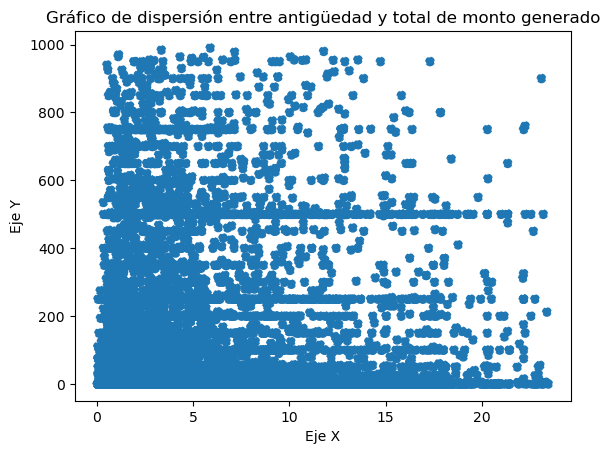

In [664]:
# Crea un gráfico de dispersión entre antiguedad y total vendido
sellers_ventas_o=sellers_ventas[sellers_ventas['unidades_vendidas'] < 1000]
plt.scatter(sellers_ventas_o['antiguedad_seller']/365, sellers_ventas_o['unidades_vendidas'], linestyle='--')

# Agrega títulos y etiquetas al gráfico
plt.title('Gráfico de dispersión entre antigüedad y total de monto generado')
plt.xlabel('Eje X')
plt.ylabel('Eje Y')

# Muestra el gráfico
plt.show()

## Segmento antiguedad

In [675]:
sellers_ventas = sellers_ventas[sellers_ventas['cat_id'].notna()]
sellers_ventas['seg_antiguedad_seller'] = np.select(
    [
     (sellers_ventas['antiguedad_seller'] <360) ,
     (sellers_ventas['antiguedad_seller'] >=360) & (sellers_ventas['antiguedad_seller'] <720),
     (sellers_ventas['antiguedad_seller'] >=-720) 	& (sellers_ventas['antiguedad_seller']  < 1080),
     (sellers_ventas['antiguedad_seller'] >=1080 ) & (sellers_ventas['antiguedad_seller']  < 1440),
     (sellers_ventas['antiguedad_seller'] >=1800 ) 
    ],
    [
        '1 año',
        '2 años',
        '3 años',
        '4 años',
        '5 años'
 ],
    default='SC'
)



In [683]:

describe_seller=sellers_ventas.groupby('seg_antiguedad_seller').describe()
describe_seller.to_excel('output/sellers_ventas_describe_'+pais+'_'+str(offset)+'.xlsx')


In [150]:

###Descriptivo
#Categorias
category_ventas = pysqldf("SELECT b.name,count(*) as cantidad_item,sum(sold_quantity) as unidades_vendidas,sum(sold_quantity*price) as total_generado  FROM df_final a left join categories b on a.cat_id=b.id group by b.name ")
#Export Excel
category_ventas.to_excel('output/category_ventas_'+pais+'_'+str(offset)+'.xlsx', index=False)
# Seller
df_seller3=df_seller2.drop_duplicates(subset=('cat_id','seller_id'))
df_seller3['tasa_cancelados']=df_seller3['seller_seller_reputation.transactions.canceled']/df_seller3[ 'seller_seller_reputation.transactions.total']
df_seller3['tasa_realizados']=df_seller3['seller_seller_reputation.transactions.completed']/df_seller3[ 'seller_seller_reputation.transactions.total']

sellers_ventas = pysqldf("SELECT cat_id,seller_id,count(*) as cantidad_item,max(seg_antiguedad_seller) as seg_antiguedad_seller,max(antiguedad_seller) as antiguedad_seller,sum(sold_quantity) as unidades_vendidas,sum(sold_quantity*price) as total_generado FROM df_final   group by cat_id,seller_id ")
sellers_ventas = sellers_ventas.merge(df_seller3, how='left', on=['cat_id','seller_id'])
#Export Excel
sellers_ventas.to_excel('output/sellers_ventas_'+pais+'_'+str(offset)+'.xlsx', index=False)

## Item
#item_ventas = pysqldf("SELECT cat_id,id,title,count(*) as cantidad ,max(seg_antiguedad_seller) as seg_antiguedad_seller,sum(sold_quantity*price) as total_generado FROM df_final   group by id,title ")
#Export Excel
#item_ventas.to_excel('output/item_ventas_'+pais+'_'+str(offset)+'.xlsx', index=False)

C:\Users\svescovij\AppData\Local\Temp\ipykernel_47000\4235796920.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_seller3['tasa_cancelados']=df_seller3['seller_seller_reputation.transactions.canceled']/df_seller3[ 'seller_seller_reputation.transactions.total']
C:\Users\svescovij\AppData\Local\Temp\ipykernel_47000\4235796920.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_seller3['tasa_realizados']=df_seller3['seller_seller_reputation.transactions.completed']/df_seller3[ 'seller_seller_reputatio

## Segmentacion K-Means

In [280]:
#features = ['cantidad_item','antiguedad_seller','unidades_vendidas','total_generado','seller_seller_reputation.transactions.ratings.positive','tasa_cancelados','tasa_realizados']
features = ['antiguedad_seller','unidades_vendidas','total_generado']

imputer = SimpleImputer(strategy='mean')

X = imputer.fit_transform(sellers_ventas[features])
# Create the KMeans model
kmeans = KMeans(n_clusters=2)

# Fit the model to the data
kmeans.fit(X)

# Predict the cluster labels
labels = kmeans.predict(imputer.fit_transform(sellers_ventas[features]))

c:\Users\svescovij\AppData\Local\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


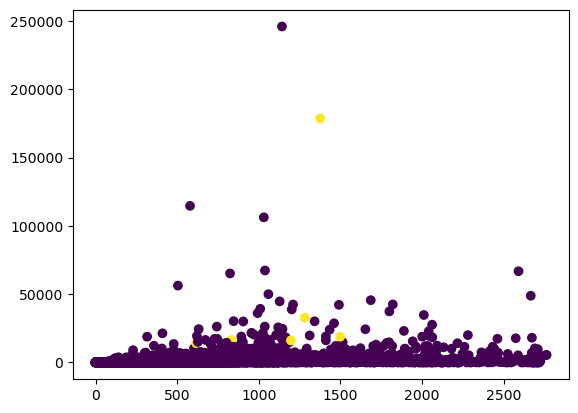

In [160]:
plt.scatter(X[:, 0], X[:, 1], c=labels)
plt.show()

In [288]:
distancias

array([2.99365415e+09, 3.02405397e+09, 3.38249715e+09, ...,
                  nan,            nan,            nan])

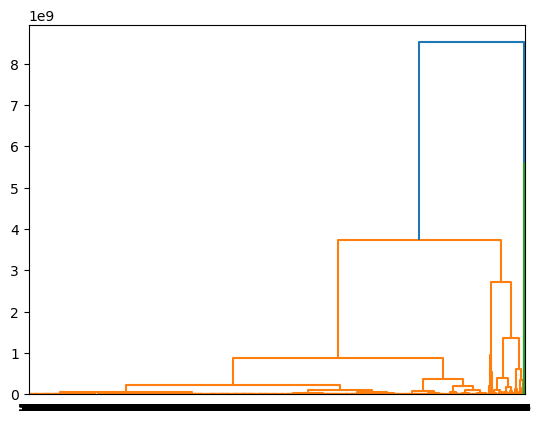

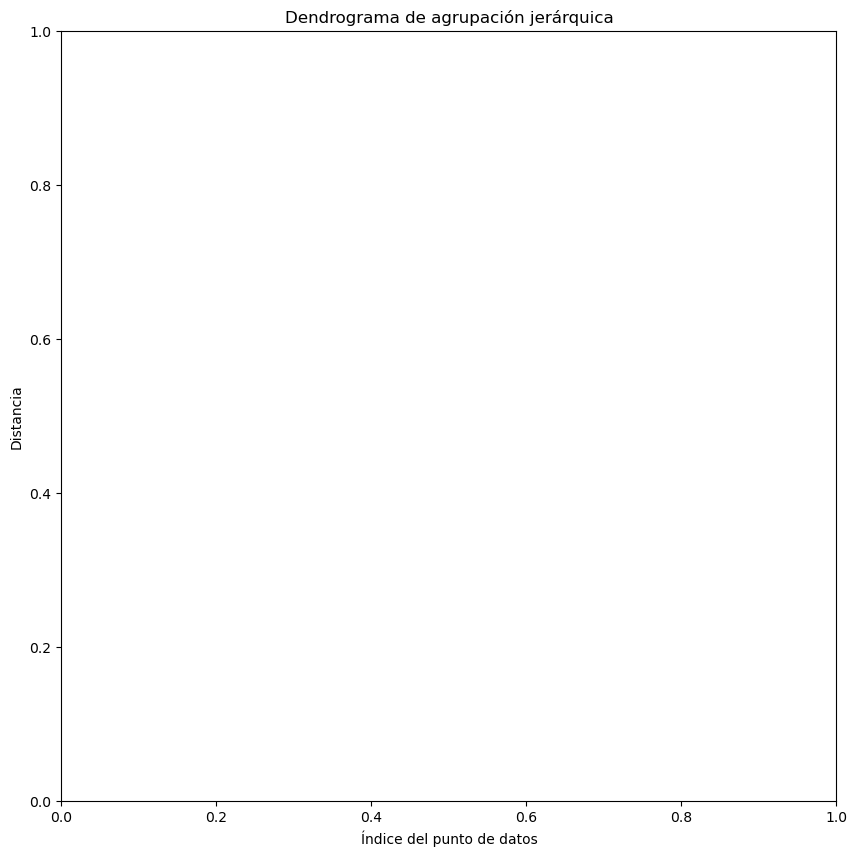

In [289]:
# Aglomeracion jerarquica
# Calcula la distancia entre los puntos de datos
from scipy.spatial.distance import pdist
distancias = pdist(sellers_ventas[features])
distancias_filtrados = distancias[np.isfinite(distancias)]
# Realiza la agrupación jerárquica
matriz_enlaces = linkage(distancias_filtrados, method='ward')

# Crea el dendrograma
dendograma = dendrogram(matriz_enlaces, leaf_rotation=0, leaf_font_size=6)

# Muestra el dendrograma
plt.figure(figsize=(10, 10))
plt.title('Dendrograma de agrupación jerárquica')
plt.xlabel('Índice del punto de datos')
plt.ylabel('Distancia')
plt.show()

In [322]:
# Calcula el coeficiente de variación
sellers_ventas.std() / sellers_ventas.mean()

C:\Users\svescovij\AppData\Local\Temp\ipykernel_47000\1242360873.py:2: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  sellers_ventas.std() / sellers_ventas.mean()
C:\Users\svescovij\AppData\Local\Temp\ipykernel_47000\1242360873.py:2: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  sellers_ventas.std() / sellers_ventas.mean()


seller_id                                                 0.737181
cantidad_item                                             3.643857
antiguedad_seller                                         0.848898
unidades_vendidas                                         5.359778
total_generado                                            5.842281
prom_health                                               0.171025
seller_car_dealer                                         8.788877
seller_seller_reputation.transactions.canceled            2.467658
seller_seller_reputation.transactions.completed           2.411176
seller_seller_reputation.transactions.ratings.positive    0.420577
seller_seller_reputation.transactions.total               2.408062
tasa_cancelados                                           1.644783
tasa_realizados                                           0.097839
dtype: float64

## Sellers por quintiles

In [641]:

sellers_ventas

,cat_id,seller_id,cantidad_item,seg_antiguedad_seller,antiguedad_seller,unidades_vendidas,total_generado,prom_health,id,category_id,...,seller_seller_reputation.level_id,seller_seller_reputation.power_seller_status,seller_seller_reputation.transactions.canceled,seller_seller_reputation.transactions.completed,seller_seller_reputation.transactions.ratings.positive,seller_seller_reputation.transactions.total,tasa_cancelados,tasa_realizados,quintil_total_generado,pon_quintil_total_generado
328,MLC1000,4155811,3,5 años,6017.0,452,65633480.0,NaN,MLC901129734,MLC172568,...,5_green,None,63.0,792.0,0.80,855.0,0.073684,0.926316,"(8319430.0, 5456565350.0]",7530.0
329,MLC1000,6941319,4,5 años,5975.0,5775,27654750.0,0.773333,MLC1068535408,MLC49334,...,5_green,platinum,3512.0,64391.0,0.91,67903.0,0.051721,0.948279,"(8319430.0, 5456565350.0]",7531.0
330,MLC1000,8465190,1,5 años,7813.0,100,7649100.0,NaN,MLC979570645,MLC3697,...,5_green,gold,194.0,2664.0,0.86,2858.0,0.067880,0.932120,"(1870230.0, 8319430.0]",5021.0
331,MLC1000,9764930,1,5 años,7722.0,0,0.0,NaN,MLC1685309790,MLC4075,...,5_green,platinum,310.0,5865.0,0.95,6175.0,0.050202,0.949798,"(-0.001, 198495.0]",1.0
332,MLC1000,14510865,14,5 años,4242.0,810,23181900.0,0.900000,MLC964713058,MLC1002,...,5_green,gold,41.0,971.0,0.99,1012.0,0.040514,0.959486,"(8319430.0, 5456565350.0]",7532.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10885,MLC5726,1333521224,3,1 año,131.0,250,40217800.0,NaN,MLC1424673588,MLC30850,...,5_green,platinum,44.0,763.0,1.00,807.0,0.054523,0.945477,"(8319430.0, 5456565350.0]",10039.0
10886,MLC5726,1352057240,1,1 año,105.0,1,32990.0,NaN,MLC1799750752,MLC162503,...,3_yellow,None,2.0,18.0,0.00,20.0,0.100000,0.900000,"(-0.001, 198495.0]",2507.0
10887,MLC5726,1370453172,1,1 año,80.0,2,13642.0,NaN,MLC1388899843,MLC439836,...,5_green,None,3.0,61.0,0.00,64.0,0.046875,0.953125,"(-0.001, 198495.0]",2508.0
10888,MLC5726,1370875693,1,1 año,79.0,5,49375.0,NaN,MLC1720123102,MLC429556,...,5_green,None,5.0,28.0,0.00,33.0,0.151515,0.848485,"(-0.001, 198495.0]",2509.0


In [676]:
## Parametro percentil; 5 quintil,10 deciles...
percentil=5
name='quintil_'
atributos = ['total_generado','unidades_vendidas']
for q in atributos:
    sellers_ventas[name+q]=pd.qcut(sellers_ventas[q], q = [i/percentil for i  in range(percentil+1)], duplicates='drop',labels=[1,2,3,4,5])       



In [677]:
## Parametro percentil; 5 quintil,10 deciles...
percentil=3
name='dos_'
atributos = ['cantidad_item']
for q in atributos:
    sellers_ventas[name+q]=pd.qcut(sellers_ventas[q], q = [i/percentil for i  in range(percentil+1)], duplicates='drop',labels=[1,2])       

In [678]:
sellers_ventas = pysqldf("SELECT *, quintil_total_generado*quintil_unidades_vendidas*dos_cantidad_item  as ponderador FROM sellers_ventas")
sellers_ventas['Segmentacion']=pd.qcut(sellers_ventas['ponderador'], q = [i/5 for i  in range(6)], duplicates='drop',labels=['Q1','Q2','Q3','Q4','Q5'])

In [679]:
sellers_ventas.groupby('Segmentacion').describe()

seller_id                                                       \
                 count          mean           std        min           25%   
Segmentacion                                                                  
Q1              2103.0  4.922806e+08  4.200718e+08    92871.0  1.525818e+08   
Q2              2016.0  6.137147e+08  4.055966e+08   239987.0  2.563634e+08   
Q3              1952.0  5.957622e+08  3.982257e+08   492540.0  2.498323e+08   
Q4              2172.0  5.150271e+08  3.574264e+08  1505006.0  2.172389e+08   
Q5              1796.0  4.644649e+08  3.335588e+08   512896.0  2.119891e+08   

                                                      cantidad_item            \
                      50%           75%           max         count      mean   
Segmentacion                                                                    
Q1            335284187.0  7.352053e+08  1.417178e+09        2103.0  1.795530   
Q2            566584506.0  1.023441e+09  1.415772e+09        2016.0  1.183532   
Q3            539695577.0  1.006101e+09  1.414349e+09        1952.0  1.716701   
Q4            460760203.0  7.309307e+08  1.415772e+09        2172.0  2.157919   
Q5            384102667.5  6.611591e+08  1.334288e+09        1796.0  9.556793   

              ... tasa_realizados           ponderador                       \
              ...             75%       max      count       mean       std   
Segmentacion  ...                                                             
Q1            ...        0.969675  1.000000     2103.0   1.336662  0.472681   
Q2            ...        0.966671  1.000000     2016.0   4.724206  0.966090   
Q3            ...        0.967328  1.000000     1952.0  10.361168  1.683942   
Q4            ...        0.968461  0.996700     2172.0  19.287293  3.533790   
Q5            ...        0.970936  0.989846     1796.0  45.326281  6.797542   

                                            
               min   25%   50%   75%   max  
Segmentacion                                
Q1             1.0   1.0   1.0   2.0   2.0  
Q2             3.0   4.0   4.0   6.0   6.0  
Q3             8.0   9.0  12.0  12.0  12.0  
Q4            15.0  16.0  20.0  24.0  25.0  
Q5            30.0  40.0  50.0  50.0  50.0  

[5 rows x 112 columns]

In [685]:
describe_seller=sellers_ventas.groupby('Segmentacion').describe()
describe_seller.to_excel('output/segmento_'+pais+'_'+str(offset)+'.xlsx')